## Dataset Loading

Load real-world benchmark datasets for empirical evaluation.

In [ ]:
# Import necessary libraries for real-world dataset processing
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
import sys
import os
import random

from scipy.stats import ks_2samp, wasserstein_distance
from scipy.io import arff  # For loading ARFF files (Airlines dataset)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from river import datasets

# Load from ARFF file
from scipy.io import arff

# Setup paths for local modules
sys.path.insert(0, os.path.abspath('../backup'))
# Random seed configuration
RANDOM_SEED = random.randint(0, 1000000)

# Import drift detection methods (from backup folder)
from shape_dd import shape, shape_adaptive
from dawidd import dawidd
from d3 import d3
from ks import ks
from mmd import mmd


In [ ]:
# Methods to evaluate
window_methods = [
    'D3', 
    'DAWIDD', 
    'ShapeDD',              
    'ShapeDD_Improved',      
]

streaming_methods = [
    'ADWIN',
    'DDM', 
    'EDDM', 
    'HDDM_A', 
    'HDDM_W', 
    'FHDDM'
    ]


In [3]:
def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb


In [ ]:
def load_datasets(synthetic_size=60000, seed=RANDOM_SEED):
    """
    Load both real-world and synthetic datasets for concept drift benchmarking.
    
    Real-world datasets:
    - Electricity (Elec2): 45,312 samples, 8 features (after removing target)
    - Airlines: Flight delay prediction dataset
    
    Synthetic datasets (with known drift points):
    - SEA: Drift at 15000, 30000, 45000 (4 concepts)
    - Hyperplane: Gradual drift every 10000 samples (rotating hyperplane)
    - LED: Abrupt drift at 20000, 40000 (3 concepts)
    
    Parameters:
    -----------
    synthetic_size : int
        Number of samples to generate for synthetic datasets
    seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict
        Dictionary containing dataset information with keys:
        - 'name': Dataset name
        - 'X': Features (numpy array)
        - 'y': Labels (numpy array)
        - 'drift_points': List of known drift locations (None for real-world)
        - 'drift_type': 'abrupt', 'gradual', or 'unknown'
    """
    datasets_dict = {}
    
    print("=" * 70)
    print("LOADING DATASETS FOR CONCEPT DRIFT BENCHMARK")
    print("=" * 70)
    
    # ========================================================================
    # REAL-WORLD DATASETS
    # ========================================================================
    print("\n[1] REAL-WORLD DATASETS")
    print("-" * 70)
    
    # --- Electricity (Elec2) Dataset ---
    try:
        print("  Loading Electricity (Elec2) dataset...")
        df_elec2 = pd.read_csv('../datasets/electricity.csv')
        X_elec2 = df_elec2.drop(columns=['class']).to_numpy()
        y_elec2 = df_elec2['class'].to_numpy()
        
        datasets_dict['Electricity'] = {
            'name': 'Electricity',
            'X': X_elec2,
            'y': y_elec2,
            'drift_points': None,  # Unknown drift locations
            'drift_type': 'unknown',
            'description': 'Electricity price prediction dataset with concept drift'
        }
        print(f"    ✓ Electricity: {X_elec2.shape[0]:,} samples, {X_elec2.shape[1]} features")
    except Exception as e:
        print(f"    ✗ Failed to load Electricity dataset: {e}")
    
    # --- Airlines Dataset ---
    try:
        print("  Loading Airlines dataset...")
        # Try to load from CSV first, then ARFF if needed
        try:
            df_airline = pd.read_csv('../datasets/airlines.csv')
        except:
            data, meta = arff.loadarff('../datasets/airlines.arff')
            df_airline = pd.DataFrame(data)
            
            # Decode byte strings if present
            for col in df_airline.columns:
                if df_airline[col].dtype == object:
                    try:
                        df_airline[col] = df_airline[col].str.decode('utf-8')
                    except:
                        pass
        
        # Identify target column (usually 'class' or 'delay')
        target_col = None
        for col in ['class', 'delay', 'Delay']:
            if col in df_airline.columns:
                target_col = col
                break
        
        if target_col:
            # Convert categorical features to numeric
            df_airline_numeric = df_airline.copy()
            for col in df_airline_numeric.columns:
                if df_airline_numeric[col].dtype == object:
                    df_airline_numeric[col] = pd.Categorical(df_airline_numeric[col]).codes
            
            X_airline = df_airline_numeric.drop(columns=[target_col]).to_numpy()
            y_airline = df_airline_numeric[target_col].to_numpy()
        else:
            # If no clear target, use all features for drift detection
            df_airline_numeric = df_airline.copy()
            for col in df_airline_numeric.columns:
                if df_airline_numeric[col].dtype == object:
                    df_airline_numeric[col] = pd.Categorical(df_airline_numeric[col]).codes
            
            X_airline = df_airline_numeric.to_numpy()
            y_airline = np.zeros(len(X_airline))  # Dummy labels
        
        datasets_dict['Airlines'] = {
            'name': 'Airlines',
            'X': X_airline,
            'y': y_airline,
            'drift_points': None,  # Unknown drift locations
            'drift_type': 'unknown',
            'description': 'Flight delay prediction with seasonal patterns'
        }
        print(f"    ✓ Airlines: {X_airline.shape[0]:,} samples, {X_airline.shape[1]} features")
    except Exception as e:
        print(f"    ✗ Failed to load Airlines dataset: {e}")
    
    # ========================================================================
    # SYNTHETIC DATASETS (with known drift points)
    # ========================================================================
    print("\n[2] SYNTHETIC DATASETS (with ground-truth drift points)")
    print("-" * 70)
    
    # --- SEA Dataset (Abrupt Drift) ---
    try:
        print("  Generating SEA dataset (abrupt drift)...")
        from river.datasets import synth
        
        # SEA has 4 concepts/variants: 0, 1, 2, 3
        drift_points_sea = [15000, 30000, 45000]
        
        X_sea_list, y_sea_list = [], []
        
        # Define which variant to use for each segment
        # Segment 1: [0, 15000) → variant 0
        # Segment 2: [15000, 30000) → variant 1
        # Segment 3: [30000, 45000) → variant 2
        # Segment 4: [45000, 60000) → variant 3
        variants = [0, 1, 2, 3]
        segment_boundaries = [0] + drift_points_sea + [synthetic_size]
        
        for seg_idx in range(len(variants)):
            start_idx = segment_boundaries[seg_idx]
            end_idx = segment_boundaries[seg_idx + 1]
            segment_size = end_idx - start_idx
            
            # Create stream with specific variant for this segment
            stream = synth.SEA(seed=seed, variant=variants[seg_idx])
            
            for i, (x, y) in enumerate(stream.take(segment_size)):
                X_sea_list.append(list(x.values()))
                y_sea_list.append(y)
        
        X_sea = np.array(X_sea_list)
        y_sea = np.array(y_sea_list)
        
        datasets_dict['SEA'] = {
            'name': 'SEA',
            'X': X_sea,
            'y': y_sea,
            'drift_points': drift_points_sea,
            'drift_type': 'abrupt',
            'description': 'SEA concepts with abrupt drift at regular intervals'
        }
        print(f"    ✓ SEA: {X_sea.shape[0]:,} samples, {X_sea.shape[1]} features")
        print(f"      Drift points: {drift_points_sea}")
    except Exception as e:
        print(f"    ✗ Failed to generate SEA dataset: {e}")
    
    # --- Hyperplane Dataset (Gradual Drift) ---
    try:
        print("  Generating Hyperplane dataset (gradual drift)...")
        from river.datasets import synth
        
        # Hyperplane with gradual drift - rotation every 10000 samples
        drift_points_hyperplane = list(range(10000, synthetic_size, 10000))
        
        X_hyp_list, y_hyp_list = [], []
        # mag_change controls drift magnitude, sigma controls noise
        stream = synth.Hyperplane(seed=RANDOM_SEED, n_features=10, n_drift_features=2, 
                                   mag_change=0.001, noise_percentage=0.1)
        for i, (x, y) in enumerate(stream.take(synthetic_size)):
            X_hyp_list.append(list(x.values()))
            y_hyp_list.append(y)
        
        X_hyp = np.array(X_hyp_list)
        y_hyp = np.array(y_hyp_list)
        
        datasets_dict['Hyperplane'] = {
            'name': 'Hyperplane',
            'X': X_hyp,
            'y': y_hyp,
            'drift_points': drift_points_hyperplane,
            'drift_type': 'gradual',
            'description': 'Rotating hyperplane with gradual continuous drift'
        }
        print(f"    ✓ Hyperplane: {X_hyp.shape[0]:,} samples, {X_hyp.shape[1]} features")
        print(f"      Drift points: {drift_points_hyperplane}")
    except Exception as e:
        print(f"    ✗ Failed to generate Hyperplane dataset: {e}")
    
    # --- LED Dataset (Abrupt Drift) ---
    try:
        print("  Generating LED dataset (abrupt drift)...")
        from river.datasets import synth
        
        # LED with abrupt drift at 1/3 and 2/3 points
        drift_points_led = [synthetic_size // 3, 2 * synthetic_size // 3]
        
        X_led_list, y_led_list = [], []
        # We'll simulate drift by changing noise level at drift points
        for i in range(synthetic_size):
            if i < drift_points_led[0]:
                noise = 0.0  # Concept 1: no noise
            elif i < drift_points_led[1]:
                noise = 0.1  # Concept 2: 10% noise
            else:
                noise = 0.2  # Concept 3: 20% noise
            
            stream = synth.LED(seed=seed + i, noise_percentage=noise)
            x, y = next(iter(stream.take(1)))
            X_led_list.append(list(x.values()))
            y_led_list.append(y)
        
        X_led = np.array(X_led_list)
        y_led = np.array(y_led_list)
        
        datasets_dict['LED'] = {
            'name': 'LED',
            'X': X_led,
            'y': y_led,
            'drift_points': drift_points_led,
            'drift_type': 'abrupt',
            'description': 'LED display with abrupt drift (changing noise levels)'
        }
        print(f"    ✓ LED: {X_led.shape[0]:,} samples, {X_led.shape[1]} features")
        print(f"      Drift points: {drift_points_led}")
    except Exception as e:
        print(f"    ✗ Failed to generate LED dataset: {e}")
    
    # ========================================================================
    # SUMMARY
    # ========================================================================
    print("\n" + "=" * 70)
    print(f"DATASET LOADING COMPLETE: {len(datasets_dict)} datasets loaded")
    print("=" * 70)
    
    for name, data in datasets_dict.items():
        drift_info = f"Drift: {len(data['drift_points'])} points" if data['drift_points'] else "Drift: Unknown"
        print(f"  • {name:15s} - {data['X'].shape[0]:6,d} samples × {data['X'].shape[1]:2d} features | {drift_info}")
    
    print("\n")
    
    return datasets_dict


In [5]:
def visualize_stream(dataset_info, sample_rate=100, figsize=(15, 6)):
    """
    Visualize data stream with drift points marked.
    
    Parameters:
    -----------
    dataset_info : dict
        Dataset dictionary from load_datasets()
    sample_rate : int
        Plot every Nth sample for efficiency
    figsize : tuple
        Figure size
    """
    X = dataset_info['X']
    y = dataset_info['y']
    drift_points = dataset_info['drift_points']
    name = dataset_info['name']
    
    # Sample data for visualization
    indices = np.arange(0, len(X), sample_rate)
    X_sample = X[indices]
    y_sample = y[indices]
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot 1: First feature over time (or PCA if high-dimensional)
    if X.shape[1] > 1:
        # Use first principal component for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=1)
        feature_values = pca.fit_transform(X_sample).flatten()
        feature_label = 'First Principal Component'
    else:
        feature_values = X_sample.flatten()
        feature_label = 'Feature Value'
    
    axes[0].plot(indices, feature_values, 'b-', alpha=0.6, linewidth=0.8)
    axes[0].set_ylabel(feature_label, fontsize=11)
    axes[0].set_title(f'{name} Dataset - Data Stream Visualization', fontsize=13, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Mark drift points
    if drift_points:
        for dp in drift_points:
            axes[0].axvline(x=dp, color='red', linestyle='--', linewidth=2, alpha=0.7, label='True Drift')
        # Remove duplicate labels
        handles, labels = axes[0].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        axes[0].legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Plot 2: Label distribution over time (classification accuracy)
    if len(np.unique(y)) <= 10:  # Only for classification problems
        axes[1].scatter(indices, y_sample, c=y_sample, cmap='viridis', alpha=0.5, s=10)
        axes[1].set_ylabel('Class Label', fontsize=11)
    else:
        axes[1].plot(indices, y_sample, 'g-', alpha=0.6, linewidth=0.8)
        axes[1].set_ylabel('Target Value', fontsize=11)
    
    axes[1].set_xlabel('Sample Index', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Mark drift points on second plot too
    if drift_points:
        for dp in drift_points:
            axes[1].axvline(x=dp, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Optional: Quick visualization of one dataset
# Uncomment to visualize a specific dataset:
# visualize_stream(benchmark_datasets['SEA'], sample_rate=50)


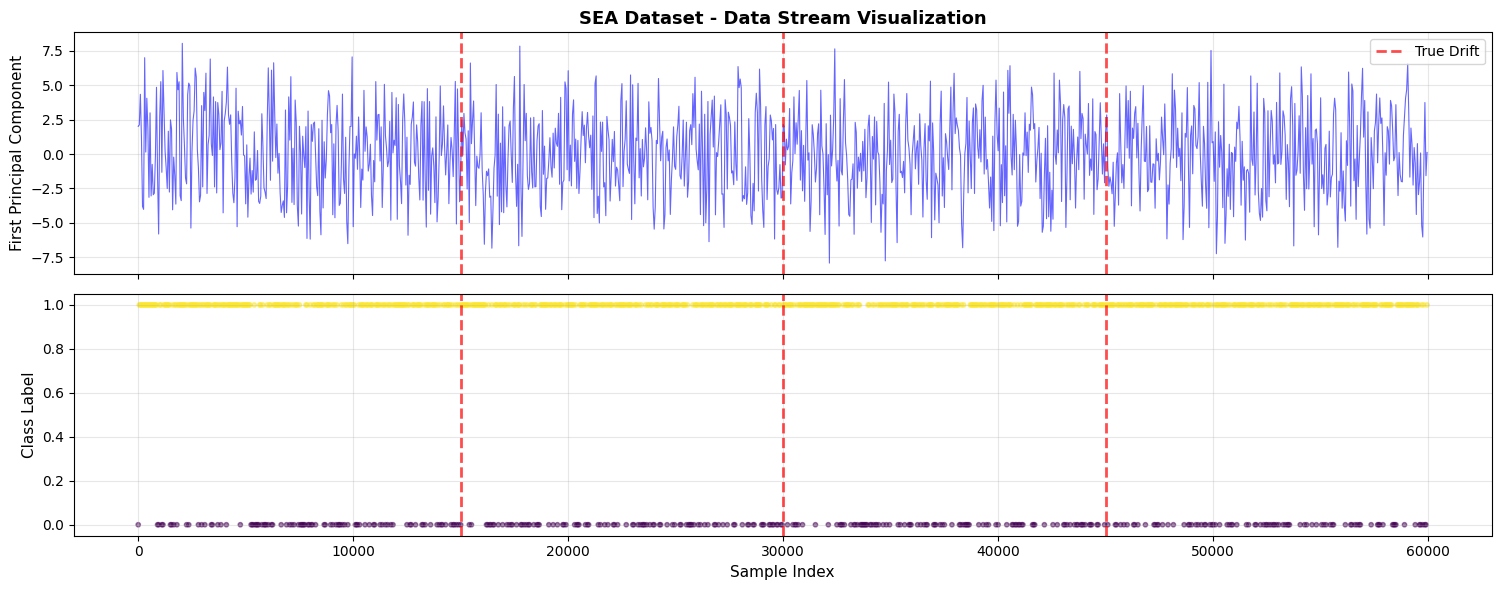

In [13]:
visualize_stream(benchmark_datasets['SEA'], sample_rate=50)


In [6]:
# Load all datasets using the benchmark function
benchmark_datasets = load_datasets(synthetic_size=60000, seed=42)

# Display dataset information
print("\n📊 BENCHMARK DATASETS SUMMARY")
print("=" * 80)
for name, dataset in benchmark_datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {dataset['X'].shape[0]:,} samples × {dataset['X'].shape[1]} features")
    print(f"  Type: {dataset['drift_type'].upper()}")
    print(f"  Description: {dataset['description']}")
    if dataset['drift_points']:
        print(f"  Ground-truth drift points: {dataset['drift_points']}")
        print(f"  Number of concepts: {len(dataset['drift_points']) + 1}")


LOADING DATASETS FOR CONCEPT DRIFT BENCHMARK

[1] REAL-WORLD DATASETS
----------------------------------------------------------------------
  Loading Electricity (Elec2) dataset...
    ✓ Electricity: 45,312 samples, 8 features
  Loading Airlines dataset...
    ✓ Airlines: 539,383 samples, 7 features

[2] SYNTHETIC DATASETS (with ground-truth drift points)
----------------------------------------------------------------------
  Generating SEA dataset (abrupt drift)...
    ✓ SEA: 60,000 samples, 3 features
      Drift points: [15000, 30000, 45000]
  Generating Hyperplane dataset (gradual drift)...
    ✓ Hyperplane: 60,000 samples, 10 features
      Drift points: [10000, 20000, 30000, 40000, 50000]
  Generating LED dataset (abrupt drift)...
    ✓ LED: 60,000 samples, 7 features
      Drift points: [20000, 40000]

DATASET LOADING COMPLETE: 5 datasets loaded
  • Electricity     - 45,312 samples ×  8 features | Drift: Unknown
  • Airlines        - 539,383 samples ×  7 features | Drift: Unkn

In [7]:
# Helper Function: Window-Based Method Evaluation

def evaluate_window_based_method_batched(X, method_name, batch_size=1000, chunk_size=150, overlap=100, 
                                          d3_threshold=0.5, dawidd_alpha=0.05, shape_alpha=0.05):
    """
    Evaluate window-based methods on data.
    
    ShapeDD variants require batch processing (memory-intensive - process entire batch at once).
    Other methods (D3, DAWIDD, KS, MMD) use sliding windows and can process the full dataset.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Input data array
    method_name : str
        Name of the drift detection method
    batch_size : int
        Size of each batch (only for ShapeDD variants)
    chunk_size : int
        Window size for sliding window methods
    overlap : int
        Overlap between consecutive windows
    d3_threshold : float
        Threshold for D3 drift detection
    dawidd_alpha : float
        Significance level for DAWIDD
    shape_alpha : float
        Significance level for ShapeDD variants
    
    Returns:
    --------
    dict
        Evaluation results
    """
    start_time = time.perf_counter()
    start_memory = monitor_resources()
    
    all_detections = []
    total_samples = len(X)
    cooldown = chunk_size // 2
    last_det = -10**9
    
    # === ShapeDD VARIANTS: Batch Processing (memory-intensive) ===
    if method_name in ['ShapeDD', 'ShapeDD_Improved']:
        overlap_size = int(batch_size * 0.1)  # 10% overlap between batches
        step_size = batch_size - overlap_size
        batch_count = 0
        
        for batch_idx in range(0, total_samples, step_size):
            end_idx = min(batch_idx + batch_size, total_samples)
            batch_data = X[batch_idx:end_idx]
            
            if len(batch_data) < 100:  # Skip very small batches
                continue
            
            batch_count += 1
            local_detections = []
            
            try:
                # Run ShapeDD on this batch
                if method_name == 'ShapeDD':
                    L1 = 50
                    L2 = min(250, len(batch_data))
                    shape_result = shape(batch_data, L1, L2, 2500)
                elif method_name == 'ShapeDD_Improved':
                    L1 = max(50, int(0.05 * len(batch_data)))
                    L2 = min(len(batch_data), 2 * L1)
                    shape_result = shape_adaptive(batch_data, L1, L2, 2500, sensitivity='none')
                
                # Find detections in this batch
                if len(shape_result) > 0:
                    p_values = shape_result[:, 2]
                    detection_mask = p_values < shape_alpha
                    local_detections = np.where(detection_mask)[0]
                    
                    # Convert to global coordinates and apply cooldown
                    for local_idx in local_detections:
                        global_idx = batch_idx + local_idx
                        if global_idx - last_det >= cooldown:
                            all_detections.append(global_idx)
                            last_det = global_idx
                    
            except Exception as e:
                pass
    
    # === OTHER METHODS: Sliding Window Processing (efficient) ===
    else:
        shift = chunk_size - overlap
        window_count = 0
        
        for i in range(0, total_samples - chunk_size + 1, shift):
            window_data = X[i:i + chunk_size]
            window_count += 1
            
            try:
                trigger = False
                det_pos = i + chunk_size - 1  # Detection at end of window
                
                if method_name == 'D3':
                    estimate = d3(window_data)
                    trigger = estimate > d3_threshold
                    
                elif method_name == 'DAWIDD':
                    _, estimate = dawidd(window_data, 'rbf')
                    trigger = estimate < dawidd_alpha
                    
                elif method_name == 'KS':
                    estimate = ks(window_data)
                    trigger = estimate < dawidd_alpha
                    
                elif method_name == 'MMD':
                    _, estimate = mmd(window_data)
                    trigger = estimate < dawidd_alpha
                
                # Apply cooldown and record detection
                if trigger and (det_pos - last_det >= cooldown):
                    all_detections.append(det_pos)
                    last_det = det_pos
                    
            except Exception as e:
                continue
    
    total_time = time.perf_counter() - start_time
    end_memory = monitor_resources()
    
    # Sort detections
    all_detections.sort()
    
    # Calculate metrics
    result = {
        'method': method_name,
        'paradigm': 'window',
        'detections': all_detections,
        'total_detections': len(all_detections),
        'runtime_ms': total_time * 1000.0,
        'runtime_per_instance_ms': (total_time * 1000.0) / total_samples,
        'memory_mb': max(0.0, end_memory - start_memory),
        'data_size': total_samples
    }
    
    return result


## Unified Experiment Pipeline

This section implements a unified pipeline that evaluates both window-based and streaming drift detection methods according to NotebookGoal.md requirements:

**Window-Based Methods** (batch/sliding window processing):
- D3, DAWIDD, ShapeDD, ShapeDD_Improved, KS, MMD

**Streaming Methods** (instance-by-instance with classifier):
- ADWIN, DDM, EDDM, HDDM_A, HDDM_W, FHDDM

**Evaluation Metrics**:
- Detection counts and positions
- Runtime performance  
- Memory usage
- For synthetic data: TPR, FPR, Detection Delay (MTTD)
- For classifier-based methods: Prequential Accuracy


In [ ]:
# Unified Drift Detection Evaluation Function

def run_unified_experiment(dataset_data, dataset_name, 
                          window_methods_list=None,
                          streaming_methods_list=None,
                          batch_size=1000, chunk_size=150, overlap=100,
                          use_classifier=True, warmup_size=100):
    """
    Unified pipeline that evaluates BOTH window-based and streaming drift detection methods.
    
    Parameters:
    -----------
    dataset_data : dict
        Dataset dictionary containing 'X', 'y', 'drift_points', etc.
    dataset_name : str
        Name of the dataset
    window_methods_list : list, optional
        List of window-based method names to evaluate
    streaming_methods_list : list, optional
        List of streaming method names to evaluate
    batch_size : int
        Batch size for ShapeDD (memory-intensive methods)
    chunk_size : int
        Window size for sliding window methods
    overlap : int
        Overlap between consecutive windows
    use_classifier : bool
        Whether to track classification accuracy (for streaming methods)
    warmup_size : int
        Number of initial samples for classifier training
    
    Returns:
    --------
    dict
        Comprehensive results for all methods
    """
    X = dataset_data['X']
    y = dataset_data['y']
    drift_points = dataset_data['drift_points']
    total_samples = len(X)
    
    print(f"\n{'='*80}")
    print(f"UNIFIED EXPERIMENT: {dataset_name}")
    print(f"{'='*80}")
    print(f"Samples: {total_samples:,} | Features: {X.shape[1]} | Ground-truth drifts: {drift_points}")
    
    results = {
        'dataset': dataset_name,
        'n_samples': total_samples,
        'n_features': X.shape[1],
        'drift_points': drift_points,
        'methods': {}
    }
    
    # ========================================================================
    # PART 1: Window-Based Methods (D3, DAWIDD, ShapeDD, etc.)
    # ========================================================================
    if window_methods_list:
        print(f"\n[1] WINDOW-BASED METHODS")
        print(f"    Configuration: batch_size={batch_size}, chunk_size={chunk_size}, overlap={overlap}")
        
        for method_name in window_methods_list:
            print(f"\n  → {method_name}")
            start_time = time.perf_counter()
            start_memory = monitor_resources()
            
            # Evaluate using existing function
            method_result = evaluate_window_based_method_batched(
                X, method_name, batch_size, chunk_size, overlap
            )
            
            # Store results
            results['methods'][method_name] = {
                'paradigm': 'window',
                'detections': method_result['detections'],
                'n_detections': method_result['total_detections'],
                'runtime_ms': method_result['runtime_ms'],
                'memory_mb': method_result['memory_mb']
            }
    
    # ========================================================================
    # PART 2: Streaming Methods (ADWIN, DDM, EDDM, etc.)
    # ========================================================================
    if streaming_methods_list:
        print(f"\n[2] STREAMING METHODS (with classifier)")
        print(f"    Configuration: warmup_size={warmup_size}, prequential evaluation")
        
        # Handle categorical labels - create label encoder if needed
        label_encoder = None
        if y is not None:
            # Check if labels are categorical (strings or bytes)
            if y.dtype == object or (len(y) > 0 and isinstance(y[0], (str, bytes))):
                unique_labels = np.unique(y)
                label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
                print(f"    Encoding categorical labels: {list(label_encoder.keys())}")
        
        # Initialize classifier for streaming methods
        if use_classifier and y is not None:
            from river import linear_model, preprocessing, compose, metrics
            model = compose.Pipeline(
                preprocessing.StandardScaler(),
                linear_model.LogisticRegression()
            )
            accuracy_metric = metrics.Accuracy()
        else:
            model = None
            accuracy_metric = None
        
        # Initialize streaming detectors
        from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W
        from river.drift import ADWIN
        
        streaming_detectors = {}
        for method_name in streaming_methods_list:
            if method_name == 'ADWIN':
                streaming_detectors[method_name] = ADWIN()
            elif method_name == 'DDM':
                streaming_detectors[method_name] = DDM()
            elif method_name == 'EDDM':
                streaming_detectors[method_name] = EDDM()
            elif method_name == 'HDDM_A':
                streaming_detectors[method_name] = HDDM_A()
            elif method_name == 'HDDM_W':
                streaming_detectors[method_name] = HDDM_W()
            # Add FHDDM if available
            
            # Initialize result storage
            results['methods'][method_name] = {
                'paradigm': 'streaming',
                'detections': [],
                'n_detections': 0,
                'accuracies': [],
                'runtime_ms': 0,
                'memory_mb': 0
            }
        
        # Stream processing
        print(f"    Streaming {total_samples:,} instances...")
        start_time = time.perf_counter()
        start_memory = monitor_resources()
        
        for i in range(total_samples):
            # Convert to dict format for River
            x_i = {f'f{j}': X[i, j] for j in range(X.shape[1])}
            
            # Handle label encoding for categorical labels
            if y is not None:
                if label_encoder:
                    y_i = label_encoder[y[i]]
                else:
                    y_i = int(y[i])
            else:
                y_i = None
            
            # Prequential evaluation: predict first, then learn
            if model and i >= warmup_size:
                y_pred = model.predict_one(x_i)
                if y_i is not None:
                    accuracy_metric.update(y_i, y_pred)
                    error = int(y_pred != y_i)
                else:
                    error = 0
            else:
                error = 0
            
            # Train classifier
            if model and y_i is not None:
                model.learn_one(x_i, y_i)
            
            # Update all streaming detectors
            for method_name, detector in streaming_detectors.items():
                try:
                    # Error-based detectors (DDM, EDDM, etc.)
                    if method_name in ['DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM', 'ADWIN']:
                        if i >= warmup_size:
                            detector.update(error)
                            if detector.drift_detected:
                                results['methods'][method_name]['detections'].append(i)
                    # Data-based detectors (ADWIN)
                except Exception as e:
                    pass
            
            # Progress indicator
            if (i + 1) % 10000 == 0:
                print(f"      Processed {i+1:,} / {total_samples:,} instances", end='\r')
        
        # Finalize streaming results
        total_time = time.perf_counter() - start_time
        end_memory = monitor_resources()
        
        for method_name in streaming_methods_list:
            results['methods'][method_name]['n_detections'] = len(results['methods'][method_name]['detections'])
            results['methods'][method_name]['runtime_ms'] = total_time * 1000.0 / len(streaming_methods_list)
            results['methods'][method_name]['memory_mb'] = max(0, end_memory - start_memory)
            
            if accuracy_metric:
                results['methods'][method_name]['accuracy'] = accuracy_metric.get()
            
            print(f"\n  → {method_name}: {results['methods'][method_name]['n_detections']} detections")
        
        if accuracy_metric:
            print(f"\n    Classifier Accuracy: {accuracy_metric.get():.4f}")
    
    # ========================================================================
    # PART 3: Compute Evaluation Metrics (if ground truth available)
    # ========================================================================
    if drift_points:
        print(f"\n[3] COMPUTING EVALUATION METRICS")
        
        for method_name, method_data in results['methods'].items():
            detections = method_data['detections']
            
            # Compute TPR, FPR, Detection Delay
            metrics_dict = compute_evaluation_metrics(
                detections, drift_points, total_samples
            )
            
            # Add to results
            method_data['metrics'] = metrics_dict
            
            print(f"  → {method_name}: TPR={metrics_dict.get('tpr', 0):.2f}, FPR={metrics_dict.get('fpr', 0):.2f}, MTTD={metrics_dict.get('avg_detection_delay', 'N/A')}")
    
    print(f"\n{'='*80}")
    print(f"COMPLETED: {dataset_name}")
    print(f"{'='*80}\n")
    
    gc.collect()
    return results


def compute_evaluation_metrics(detections, ground_truth_drifts, total_samples, tolerance=250):
    """
    Compute TPR, FPR, and MTTD for drift detection.
    
    Parameters:
    -----------
    detections : list
        Detected drift positions
    ground_truth_drifts : list
        True drift positions  
    total_samples : int
        Total number of samples
    tolerance : int
        Time window for matching detections to true drifts
    
    Returns:
    --------
    dict
        Evaluation metrics
    """
    if not ground_truth_drifts:
        return {'tpr': None, 'fpr': None, 'avg_detection_delay': None}
    
    # True Positives: detections within tolerance of true drifts
    detected_true_drifts = set()
    detection_delays = []
    
    for detection in detections:
        for true_drift in ground_truth_drifts:
            if abs(detection - true_drift) <= tolerance:
                detected_true_drifts.add(true_drift)
                delay = detection - true_drift
                if delay >= 0:  # Only count delays after drift
                    detection_delays.append(delay)
                break
    
    tp = len(detected_true_drifts)
    fp = len(detections) - tp
    fn = len(ground_truth_drifts) - tp
    tn = max(0, total_samples - tp - fp - fn)
    
    tpr = tp / len(ground_truth_drifts) if ground_truth_drifts else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    avg_delay = np.mean(detection_delays) if detection_delays else None
    
    return {
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'tpr': tpr,
        'fpr': fpr,
        'avg_detection_delay': avg_delay,
        'n_detections': len(detections)
    }


In [9]:
# Run Unified Experiment on All Datasets

# Configuration
BATCH_SIZE = 1000      # For ShapeDD
CHUNK_SIZE = 150       # For sliding window methods
OVERLAP = 100          # Overlap for sliding windows
WARMUP_SIZE = 100      # Initial training samples for classifier

# Define methods to evaluate
WINDOW_METHODS = ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W']

print(f"{'='*80}")
print(f"UNIFIED EXPERIMENT CONFIGURATION")
print(f"{'='*80}")
print(f"Window-based methods: {WINDOW_METHODS}")
print(f"Streaming methods: {STREAMING_METHODS}")
print(f"ShapeDD batch size: {BATCH_SIZE}")
print(f"Sliding window: chunk_size={CHUNK_SIZE}, overlap={OVERLAP}")
print(f"Classifier warmup: {WARMUP_SIZE} samples")
print(f"{'='*80}\n")

# Run experiments on all datasets
all_unified_results = []

for dataset_name, dataset_data in benchmark_datasets.items():
    result = run_unified_experiment(
        dataset_data=dataset_data,
        dataset_name=dataset_name,
        window_methods_list=WINDOW_METHODS,
        streaming_methods_list=STREAMING_METHODS,
        batch_size=BATCH_SIZE,
        chunk_size=CHUNK_SIZE,
        overlap=OVERLAP,
        use_classifier=True,
        warmup_size=WARMUP_SIZE
    )
    all_unified_results.append(result)

print(f"\n{'='*80}")
print(f"ALL EXPERIMENTS COMPLETED")
print(f"{'='*80}")
print(f"Total datasets evaluated: {len(all_unified_results)}")
print(f"Total methods per dataset: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")


UNIFIED EXPERIMENT CONFIGURATION
Window-based methods: ['D3', 'DAWIDD', 'ShapeDD', 'ShapeDD_Improved']
Streaming methods: ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W']
ShapeDD batch size: 1000
Sliding window: chunk_size=150, overlap=100
Classifier warmup: 100 samples


UNIFIED EXPERIMENT: Electricity
Samples: 45,312 | Features: 8 | Ground-truth drifts: None

[1] WINDOW-BASED METHODS
    Configuration: batch_size=1000, chunk_size=150, overlap=100

  → D3

  → DAWIDD

  → ShapeDD

  → ShapeDD_Improved

[2] STREAMING METHODS (with classifier)
    Configuration: warmup_size=100, prequential evaluation
    Encoding categorical labels: ['DOWN', 'UP']
    Streaming 45,312 instances...
      Processed 40,000 / 45,312 instances
  → ADWIN: 11 detections

  → DDM: 93 detections

  → EDDM: 193 detections

  → HDDM_A: 172 detections

  → HDDM_W: 120 detections

    Classifier Accuracy: 0.8375

COMPLETED: Electricity


UNIFIED EXPERIMENT: Airlines
Samples: 539,383 | Features: 7 | Ground-truth drifts:

In [10]:
# Convert Results to DataFrame for Analysis

# Flatten results for easy analysis
rows = []
for dataset_result in all_unified_results:
    dataset_name = dataset_result['dataset']
    drift_points = dataset_result['drift_points']
    
    for method_name, method_data in dataset_result['methods'].items():
        row = {
            'dataset': dataset_name,
            'method': method_name,
            'paradigm': method_data['paradigm'],
            'n_detections': method_data['n_detections'],
            'runtime_ms': method_data['runtime_ms'],
            'runtime_sec': method_data['runtime_ms'] / 1000.0,
            'memory_mb': method_data['memory_mb'],
            'has_ground_truth': drift_points is not None
        }
        
        # Add accuracy if available
        if 'accuracy' in method_data:
            row['accuracy'] = method_data['accuracy']
        
        # Add evaluation metrics if available
        if 'metrics' in method_data:
            metrics = method_data['metrics']
            row['tpr'] = metrics.get('tpr')
            row['fpr'] = metrics.get('fpr')
            row['mttd'] = metrics.get('avg_detection_delay')
            row['tp'] = metrics.get('tp')
            row['fp'] = metrics.get('fp')
        
        rows.append(row)

# Create DataFrame
results_df = pd.DataFrame(rows)

print("\n" + "="*100)
print("UNIFIED RESULTS SUMMARY")
print("="*100)
print(f"\nTotal evaluations: {len(results_df)}")
print(f"Datasets: {results_df['dataset'].nunique()}")
print(f"Methods: {results_df['method'].nunique()}")
print("\n")

# Display summary table
print("Performance Overview:")
print("-" * 100)
summary_cols = ['dataset', 'method', 'paradigm', 'n_detections', 'runtime_sec']
if 'accuracy' in results_df.columns:
    summary_cols.append('accuracy')
if 'tpr' in results_df.columns:
    summary_cols.extend(['tpr', 'fpr'])

display_df = results_df[summary_cols].copy()
display_df['runtime_sec'] = display_df['runtime_sec'].round(3)
if 'accuracy' in display_df.columns:
    display_df['accuracy'] = display_df['accuracy'].round(4)
if 'tpr' in display_df.columns:
    display_df['tpr'] = display_df['tpr'].round(3)
    display_df['fpr'] = display_df['fpr'].round(4)

print(display_df.to_string(index=False))
print("\n" + "="*100)

# Statistics by method
print("\nAGGREGATED STATISTICS BY METHOD:")
print("-" * 100)
method_stats = results_df.groupby('method').agg({
    'n_detections': ['mean', 'std', 'min', 'max'],
    'runtime_sec': ['mean', 'std'],
    'memory_mb': ['mean', 'std']
}).round(3)
print(method_stats)

# Statistics by dataset
print("\n\nAGGREGATED STATISTICS BY DATASET:")
print("-" * 100)
dataset_stats = results_df.groupby('dataset').agg({
    'n_detections': ['mean', 'std'],
    'runtime_sec': ['mean', 'std']
}).round(3)
print(dataset_stats)

results_df



UNIFIED RESULTS SUMMARY

Total evaluations: 45
Datasets: 5
Methods: 9


Performance Overview:
----------------------------------------------------------------------------------------------------
    dataset           method  paradigm  n_detections  runtime_sec  accuracy   tpr    fpr
Electricity               D3    window             8        2.633       NaN   NaN    NaN
Electricity           DAWIDD    window           452       21.076       NaN   NaN    NaN
Electricity          ShapeDD    window           356       17.512       NaN   NaN    NaN
Electricity ShapeDD_Improved    window           219        6.898       NaN   NaN    NaN
Electricity            ADWIN streaming            11        0.635    0.8375   NaN    NaN
Electricity              DDM streaming            93        0.635    0.8375   NaN    NaN
Electricity             EDDM streaming           193        0.635    0.8375   NaN    NaN
Electricity           HDDM_A streaming           172        0.635    0.8375   NaN    NaN
Ele

,dataset,method,paradigm,n_detections,runtime_ms,runtime_sec,memory_mb,has_ground_truth,accuracy,tpr,fpr,mttd,tp,fp
0,Electricity,D3,window,8,2632.582910,2.632583,0.085938,False,NaN,NaN,NaN,NaN,NaN,NaN
1,Electricity,DAWIDD,window,452,21075.886584,21.075887,448.660156,False,NaN,NaN,NaN,NaN,NaN,NaN
2,Electricity,ShapeDD,window,356,17511.731978,17.511732,122.089844,False,NaN,NaN,NaN,NaN,NaN,NaN
3,Electricity,ShapeDD_Improved,window,219,6898.472041,6.898472,0.000000,False,NaN,NaN,NaN,NaN,NaN,NaN
4,Electricity,ADWIN,streaming,11,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
5,Electricity,DDM,streaming,93,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
6,Electricity,EDDM,streaming,193,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
7,Electricity,HDDM_A,streaming,172,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
8,Electricity,HDDM_W,streaming,120,634.593680,0.634594,0.000000,False,0.837477,NaN,NaN,NaN,NaN,NaN
9,Airlines,D3,window,1728,26578.180446,26.578180,0.000000,False,NaN,NaN,NaN,NaN,NaN,NaN


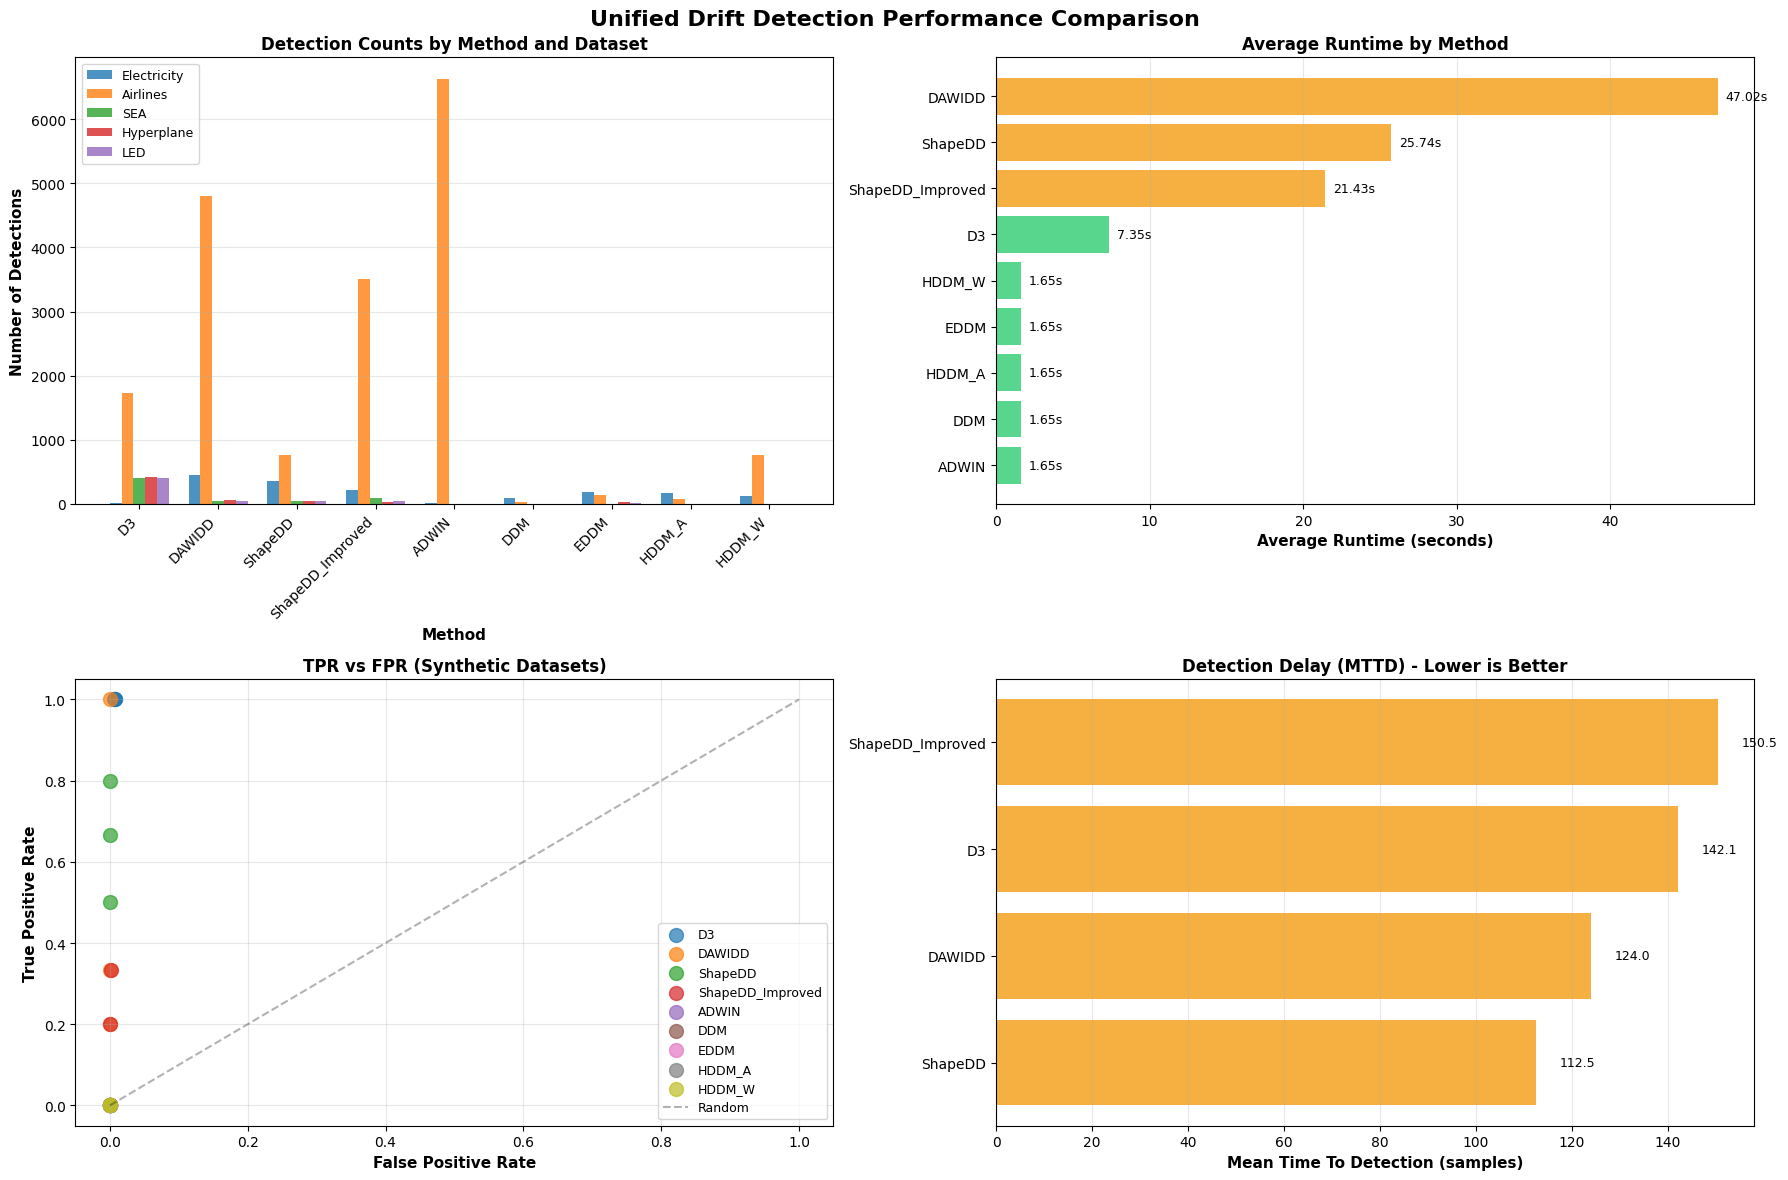


✅ Visualization complete!


In [11]:
# Unified Visualization: Performance Comparison

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Unified Drift Detection Performance Comparison', fontsize=16, fontweight='bold')

# Plot 1: Detection Counts by Method and Dataset
ax1 = axes[0, 0]
datasets = results_df['dataset'].unique()
methods = results_df['method'].unique()
x = np.arange(len(methods))
width = 0.15

for i, dataset in enumerate(datasets):
    dataset_data = results_df[results_df['dataset'] == dataset]
    counts = [dataset_data[dataset_data['method'] == m]['n_detections'].values[0] 
              if len(dataset_data[dataset_data['method'] == m]) > 0 else 0
              for m in methods]
    ax1.bar(x + i * width, counts, width, label=dataset, alpha=0.8)

ax1.set_xlabel('Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Detections', fontsize=11, fontweight='bold')
ax1.set_title('Detection Counts by Method and Dataset', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * (len(datasets) - 1) / 2)
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Runtime Performance
ax2 = axes[0, 1]
runtime_data = results_df.groupby('method')['runtime_sec'].mean().sort_values()
colors = ['#2ecc71' if x < 10 else '#f39c12' if x < 50 else '#e74c3c' 
          for x in runtime_data.values]
ax2.barh(range(len(runtime_data)), runtime_data.values, color=colors, alpha=0.8)
ax2.set_yticks(range(len(runtime_data)))
ax2.set_yticklabels(runtime_data.index)
ax2.set_xlabel('Average Runtime (seconds)', fontsize=11, fontweight='bold')
ax2.set_title('Average Runtime by Method', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(runtime_data.values):
    ax2.text(v + 0.5, i, f'{v:.2f}s', va='center', fontsize=9)

# Plot 3: TPR vs FPR (for methods with ground truth)
ax3 = axes[1, 0]
if 'tpr' in results_df.columns and 'fpr' in results_df.columns:
    synthetic_data = results_df[results_df['has_ground_truth'] == True].dropna(subset=['tpr', 'fpr'])
    
    if len(synthetic_data) > 0:
        for method in synthetic_data['method'].unique():
            method_data = synthetic_data[synthetic_data['method'] == method]
            ax3.scatter(method_data['fpr'], method_data['tpr'], 
                       label=method, s=100, alpha=0.7)
        
        ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')
        ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax3.set_title('TPR vs FPR (Synthetic Datasets)', fontsize=12, fontweight='bold')
        ax3.legend(loc='lower right', fontsize=9)
        ax3.grid(alpha=0.3)
        ax3.set_xlim(-0.05, 1.05)
        ax3.set_ylim(-0.05, 1.05)
    else:
        ax3.text(0.5, 0.5, 'No ground truth data available', 
                ha='center', va='center', transform=ax3.transAxes)
else:
    ax3.text(0.5, 0.5, 'No ground truth data available', 
            ha='center', va='center', transform=ax3.transAxes)

# Plot 4: Detection Delay (MTTD) for Synthetic Datasets
ax4 = axes[1, 1]
if 'mttd' in results_df.columns:
    mttd_data = results_df[results_df['has_ground_truth'] == True].dropna(subset=['mttd'])
    
    if len(mttd_data) > 0:
        mttd_grouped = mttd_data.groupby('method')['mttd'].mean().sort_values()
        colors_mttd = ['#2ecc71' if x < 100 else '#f39c12' if x < 250 else '#e74c3c' 
                      for x in mttd_grouped.values]
        ax4.barh(range(len(mttd_grouped)), mttd_grouped.values, color=colors_mttd, alpha=0.8)
        ax4.set_yticks(range(len(mttd_grouped)))
        ax4.set_yticklabels(mttd_grouped.index)
        ax4.set_xlabel('Mean Time To Detection (samples)', fontsize=11, fontweight='bold')
        ax4.set_title('Detection Delay (MTTD) - Lower is Better', fontsize=12, fontweight='bold')
        ax4.grid(axis='x', alpha=0.3)
        for i, v in enumerate(mttd_grouped.values):
            if not np.isnan(v):
                ax4.text(v + 5, i, f'{v:.1f}', va='center', fontsize=9)
    else:
        ax4.text(0.5, 0.5, 'No MTTD data available', 
                ha='center', va='center', transform=ax4.transAxes)
else:
    ax4.text(0.5, 0.5, 'No MTTD data available', 
            ha='center', va='center', transform=ax4.transAxes)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete!")


VISUALIZING DETECTIONS ON SYNTHETIC DATASETS

📊 SEA


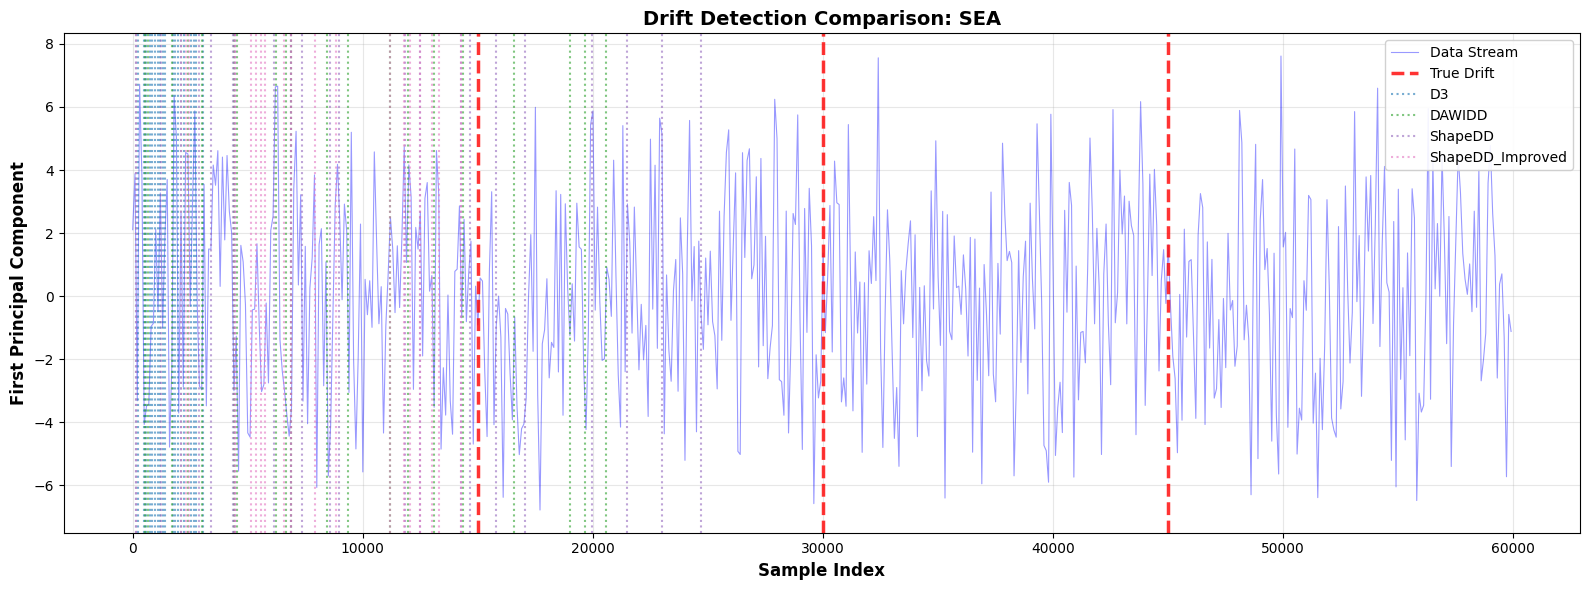


📊 Hyperplane


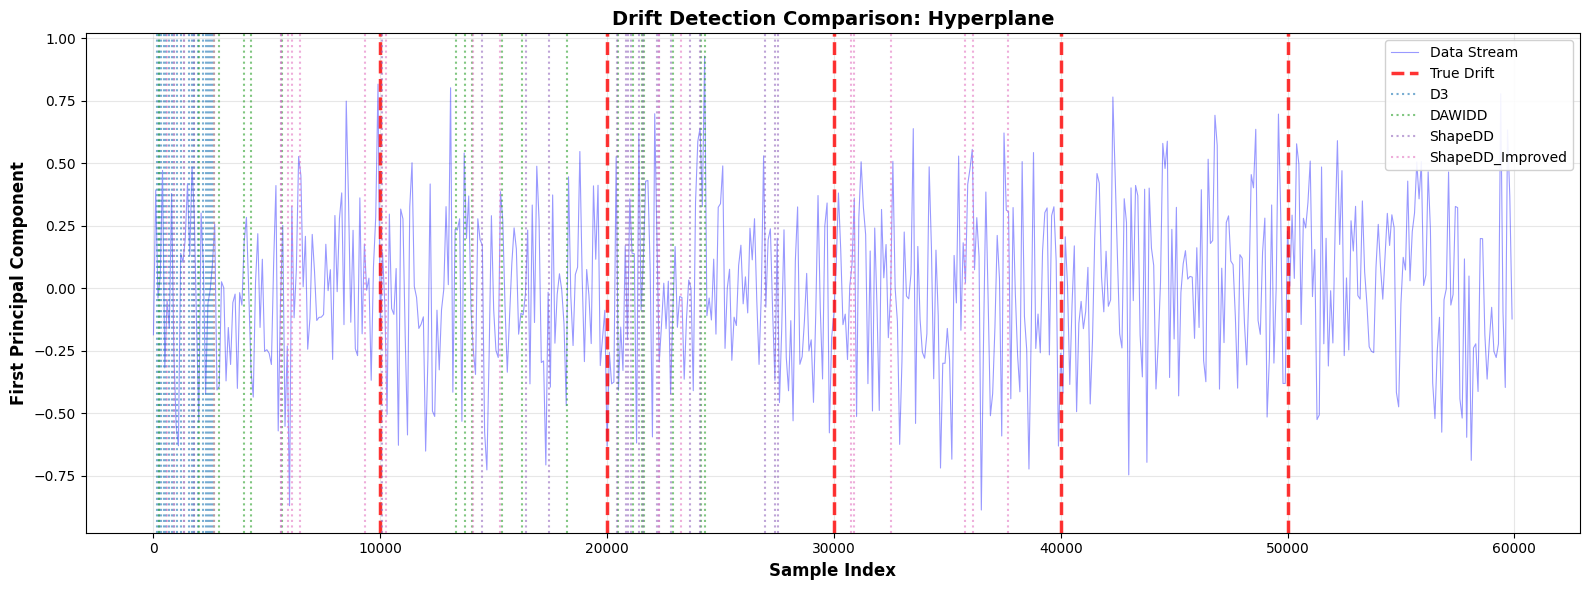


📊 LED


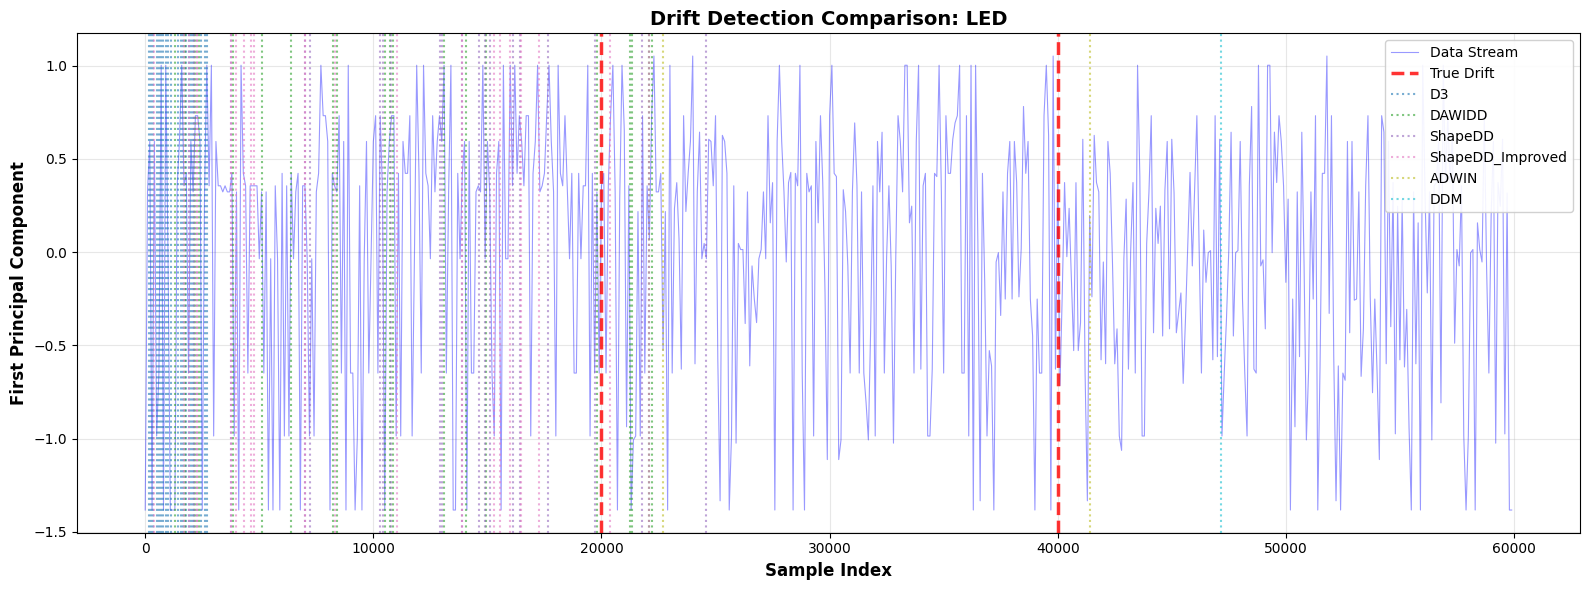

In [12]:
# Visualize Detections on Synthetic Datasets with Ground Truth

# Enhanced visualize_stream function for detection comparison
def visualize_detections(dataset_result, sample_rate=100, max_methods=6):
    """
    Visualize data stream with ground truth and detected drifts.
    """
    dataset_name = dataset_result['dataset']
    dataset_data = benchmark_datasets[dataset_name]
    
    X = dataset_data['X']
    y = dataset_data['y']
    drift_points = dataset_data['drift_points']
    
    if not drift_points:
        print(f"⚠ {dataset_name} has no ground truth drift points, skipping visualization")
        return
    
    # Sample data for visualization
    indices = np.arange(0, len(X), sample_rate)
    X_sample = X[indices]
    
    # Apply PCA if high-dimensional
    if X.shape[1] > 1:
        pca = PCA(n_components=1)
        feature_values = pca.fit_transform(X_sample).flatten()
        feature_label = 'First Principal Component'
    else:
        feature_values = X_sample.flatten()
        feature_label = 'Feature Value'
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot data stream
    ax.plot(indices, feature_values, 'b-', alpha=0.4, linewidth=0.8, label='Data Stream')
    
    # Mark ground truth drifts
    for dp in drift_points:
        ax.axvline(x=dp, color='red', linestyle='--', linewidth=2.5, alpha=0.8, 
                  label='True Drift' if dp == drift_points[0] else '')
    
    # Plot detected drifts for each method (limit to max_methods for clarity)
    colors = plt.cm.tab10(np.linspace(0, 1, max_methods))
    method_count = 0
    
    for method_name, method_data in dataset_result['methods'].items():
        if method_count >= max_methods:
            break
        
        detections = method_data['detections']
        if len(detections) > 0:
            # Plot detections as vertical lines with offset
            offset = method_count * 0.02 * (max(feature_values) - min(feature_values))
            for det in detections[:20]:  # Limit to first 20 detections for clarity
                ax.axvline(x=det, color=colors[method_count], linestyle=':', 
                          linewidth=1.5, alpha=0.6,
                          label=method_name if det == detections[0] else '')
        
        method_count += 1
    
    ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
    ax.set_ylabel(feature_label, fontsize=12, fontweight='bold')
    ax.set_title(f'Drift Detection Comparison: {dataset_name}', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize synthetic datasets with ground truth
print("="*80)
print("VISUALIZING DETECTIONS ON SYNTHETIC DATASETS")
print("="*80)

for dataset_result in all_unified_results:
    if dataset_result['drift_points']:
        print(f"\n📊 {dataset_result['dataset']}")
        visualize_detections(dataset_result, sample_rate=100)
